# Benefit-cost Analysis

Sina Khales\
Last update: 04/13/2022

## 1.	Overview:
Transportation professionals need CMFs, countermeasure service life, countermeasure costs, and crash severity costs to conduct an economic appraisal or crash-based benefit cost analysis of potential countermeasures for implementation. The objective of this analysis is to suggest the best set of countermeasures to be implemented for each location, in order to reduce the number of crashes. The best countermeasures are defined as the ones with the highest benefit/cost ratio.


## 2. Methodology:
The procedure of selecting the best countermeasure(s) for each location, comprises the following steps:
1. Identifying crash patterns for each location based on the crash data. 
2. Using the matrix_final to identify the available countermeasures for each location, based on the combination of prevailing condition/collision type, and roadway functional class & intersection type.
3.	Calculating the benefit of each countermeasure based on the CMF and crash cost, by severity level. Calculating the benefit cost (B/C) ratios based on the cost of each countermeasure.
4.	Comparing the B/C ratios and suggesting the countermeasures(s) with the highest ratio.

#### Required Tables and libraries

1. Crash data (I used the 4-year crash data (2018-2021) that I got from Joseph).
2. Roadway inventory data ('combined_segment_table' that I got from Joseph).
3. A matrix I created based on the data I got from the CMF Clearing website and the FHWA Proven Safety Countermeasures (details are not needed here!). This matrix includes the following columns: \
['Countermeasure	Condition', 'Intersection Related',	'Traffic Control Type',	'Roadway Type',	'CMF Type',	'CMF Value']


### 2.1
Crash patterns should be identified through an analysis of the crash data for all locations. When conducting a crash analysis, it is useful to create a summary table of the crashes that occurred during the study period. The table can include a summary of the roadway conditions, speeding, lighting conditions, collision type, and number of injuries or fatalities. The summary table can provide insight for identifying crash patterns. Crash patterns include the prevailing conditions (wet road, nighttime, speed related, pedestrian, and bike), and dominant collision types for each location.\
\
•	Prevailing conditions: We check if a condition is abnormal. Abnormality can be identified by comparing the crash rate with the average numbers in network scale.\
•	Dominant collision types: We select the top three types of collision as dominant. 


In [1]:
import os
import pandas as pd
import numpy as np

os.chdir(r"C:\Users\sina\Documents\Crash Frequency Prediction\Data")

In [2]:
# Import the crash data

crash_data = pd.read_csv(r"crash_table.csv")

C:\Users\sina\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (52,53) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Preprocessing steps:
1. Select only the columns that we need for the analysis 
2. Remove the records with missing segment_id 

In [3]:
# Select the columns that we need only

crash_data = crash_data[['crash_id', 'ccn', 'severity', 'collision_type', 'roadway_functional_classification', 
                        'traffic_control_type', 'num_speed', 'num_ped_involved', 'num_bike_involved', 
                        'num_escooter_involved', 'is_wet', 'is_dark', 'intersection_id', 'distance_to_intersection_center',
                        'segment_id']]

# Check
print(crash_data.shape)

# We might need to exclude the records with missing segment_ids 
crash_data.dropna(subset = ['segment_id'], inplace= True)

# Check
print(crash_data.shape)

(83582, 15)
(83089, 15)


Crash conditions are:
1) Nighttime\
2) Speeding\
3) Wet surface\
4) Pedestrian\
5) Bike

##### Note: None of the crash conditions has missing values 

#### Preprocessing steps:
1. Change the data type for those columns, which represent crash conditions.

In [4]:
crash_data[['is_dark','is_wet']] = crash_data[['is_dark','is_wet']].astype('category')

In [5]:
crash_data['is_dark'] = crash_data['is_dark'].cat.codes
crash_data['is_wet'] = crash_data['is_wet'].cat.codes

#### 2.1.1 Prevailing conditions

In [6]:
# Find the averages

nighttime_avg = crash_data.is_dark.mean()
wet_avg = crash_data.is_wet.mean()
speed_avg = crash_data.num_speed.mean()
ped_avg = crash_data.num_ped_involved.mean()
bike_avg = crash_data.num_bike_involved.mean()

avg = pd.Series([nighttime_avg, wet_avg, speed_avg, ped_avg, bike_avg], index= ['nighttime_avg', 'wet_avg','speed_avg', 'ped_avg', 'bike_avg'])

In [7]:
avg = pd.DataFrame(avg).transpose()

In [8]:
# Group the crashes based on the segment_id

crash_group = crash_data.groupby('segment_id')

# Identify the prevailing conditions for each segment

prev_cond = crash_group[['is_dark', 'is_wet', 'num_speed', 'num_ped_involved', 'num_bike_involved']].mean() > avg.values

In [9]:
# Check

display(prev_cond.head())       

,is_dark,is_wet,num_speed,num_ped_involved,num_bike_involved
segment_id,,,,,
1.0,True,True,False,False,False
2.0,False,False,True,True,True
3.0,False,True,False,True,False
4.0,False,True,False,False,True
5.0,False,True,False,False,False


In [10]:
# Create a list of prevailing conditions for each segment

pc_list = []

for lab, row in prev_cond.iterrows():
    pc_list.append({lab: list(row.index[row.values])})

In [11]:
# Check

print(pc_list[:4])

[{1.0: ['is_dark', 'is_wet']}, {2.0: ['num_speed', 'num_ped_involved', 'num_bike_involved']}, {3.0: ['is_wet', 'num_ped_involved']}, {4.0: ['is_wet', 'num_bike_involved']}]


#### 2.1.2 Dominant collision types

Collision types are:
1) angle\
2) rear end\
3) left turn\
4) right turn\
5) sideswipe\
6) head on\
7) non-collision\
8) fixed object

In [13]:
# Check

crash_data.collision_type.value_counts()

Rear End                    20451
Side Swiped                 17579
Parked Vehicle              11888
Left Turn Hit Veh.           8467
Fixed Object                 6657
Right Angle                  4570
Right Turn Hit Veh.          3196
Backing Hit Veh.             2496
Straight Hit N.M.            2101
Head On                      1181
Side Swiped with N.M.        1134
Left Turn Hit N.M.           1078
Right Turn Hit N.M.           584
Non-Collision Accident        466
Backing Hit N.M.              221
Parked Vehicle with N.M.      195
Right Angle with N.M.          19
Name: collision_type, dtype: int64

#### We have to make the collision types in the crash data consistent with what we have in the matrix

In [14]:
# 1) replace all N.M crashes with NA
crash_data.collision_type.replace(r".*\sN\.M\.", np.nan, regex= True, inplace = True)


In [15]:
# 2) replace the followings with NA too
# parked vehicle?
# backing hit veh?

crash_data.collision_type.replace(r"Parked|Backing", np.nan, regex= True, inplace = True)

In [16]:
# Check
crash_data.collision_type.value_counts()

Rear End                  20451
Side Swiped               17579
Left Turn Hit Veh.         8467
Fixed Object               6657
Right Angle                4570
Right Turn Hit Veh.        3196
Head On                    1181
Non-Collision Accident      466
Name: collision_type, dtype: int64

In [17]:
from collections import Counter

In [18]:
# Create a list of dominant collision types for each segment

dc_list = []

for name, group in crash_group:
    h = Counter(group.collision_type)
    
    # create a list of dictionaries with dominant collision types for each segment
    dc_list.append({name: [x[0] for x in h.most_common(3)]})
    

In [19]:
print(dc_list[:4])

[{1.0: [nan]}, {2.0: ['Fixed Object', nan, 'Left Turn Hit Veh.']}, {3.0: ['Right Turn Hit Veh.', 'Right Angle', 'Fixed Object']}, {4.0: [nan, 'Side Swiped']}]


#### Prevailing conditions + dominant collision types at segment level

In [20]:
a = [list(pc_list[i].values()) + list(dc_list[i].values()) for i in range(len(dc_list))]

In [21]:
import itertools

cond_all = []

for i in range(len(a)):
    cond_all.append([*itertools.chain(*a[i])])

In [22]:
b = [list(i.keys()) for i in dc_list]
b = [*itertools.chain(*b)]

In [23]:
problems_df = pd.DataFrame(cond_all, index= b, columns= [str('problem_{}'.format(i)) for i in range(1, 9)])

In [24]:
problems_df.replace("num_speed", "Speed related", regex= True, inplace = True)
problems_df.replace("num_ped_involved", "Pedestrian", regex= True, inplace = True)
problems_df.replace("num_bike_involved", "Bike", regex= True, inplace = True)
problems_df.replace("is_dark", "Nighttime", regex= True, inplace = True)
problems_df.replace("is_wet", "Wet road", regex= True, inplace = True)

#### problem_df contains prevailing consitions and dominant collision types for all roadway segments 

In [25]:
display(problems_df.head())
print(problems_df.shape)

,problem_1,problem_2,problem_3,problem_4,problem_5,problem_6,problem_7,problem_8
1.0,Nighttime,Wet road,NaN,None,None,None,None,None
2.0,Speed related,Pedestrian,Bike,Fixed Object,NaN,Left Turn Hit Veh.,None,None
3.0,Wet road,Pedestrian,Right Turn Hit Veh.,Right Angle,Fixed Object,None,None,None
4.0,Wet road,Bike,NaN,Side Swiped,None,None,None,None
5.0,Wet road,Side Swiped,Head On,NaN,None,None,None,None


(11510, 8)


#### The number of segments: 11,510

#### Add the roadway functional class to this table, using the 'combined_segment_table'

In [26]:
segment_table = pd.read_csv(r"combined_segment_table.csv")
segment_table= segment_table[['segment_id', 'traffic_control_type', 'functional_classification']]
display(segment_table.head())

,segment_id,traffic_control_type,functional_classification
0,13484,NA;NA;,Local
1,1499,NA;NA;,Local
2,1662,All-way stop;Two-way stop;,Local
3,2183,Two-way stop;All-way stop;,Local
4,12654,Two-way stop;NA;,Local


In [27]:
# Check

segment_table.traffic_control_type.value_counts()

Two-way stop;Two-way stop;           2644
Signalized;Signalized;               1650
NA;NA;                               1469
All-way stop;All-way stop;           1205
All-way stop;Two-way stop;           1091
Two-way stop;All-way stop;           1088
Signalized;Two-way stop;              885
Two-way stop;NA;                      852
Two-way stop;Signalized;              819
NA;Two-way stop;                      768
Signalized;NA;                        493
NA;Signalized;                        455
Signalized;All-way stop;              372
All-way stop;Signalized;              353
NA;All-way stop;                      276
All-way stop;NA;                      263
NA;Signalized;Signalized;               2
Signalized;Signalized;Signalized;       2
Name: traffic_control_type, dtype: int64

#### We have to make the traffic control type column consistent with the matrix content

In [28]:
import re

for lab, row in segment_table.iterrows():
    if re.search('Signalized', row.traffic_control_type) is not None:
        segment_table.loc[lab, 'traffic_control_type'] = 'Signalized'
        
    elif re.search('stop', row.traffic_control_type) is not None:
        segment_table.loc[lab, 'traffic_control_type'] = 'Stop-controlled'
        
    else:
        segment_table.loc[lab, 'traffic_control_type'] = np.nan

In [29]:
# Check:

segment_table.set_index('segment_id', inplace= True)
print(segment_table.traffic_control_type.value_counts(), '\n')
print(f"There are {segment_table.traffic_control_type.isna().sum()} segments with no traffic controls, which is only {segment_table.traffic_control_type.isna().sum()*100/segment_table.shape[0]: .2f}% of the segments")

Stop-controlled    8187
Signalized         5031
Name: traffic_control_type, dtype: int64 

There are 1469 segments with no traffic controls, which is only  10.00% of the segments


#### Join segment_table and problems_df

In [30]:
seg_prob = problems_df.merge(segment_table, left_index= True, right_index= True, how = 'inner')

#### seg_prob table contains all problem_df inputs + roway functional classification of eash segment

In [31]:
seg_prob

,problem_1,problem_2,problem_3,problem_4,problem_5,problem_6,problem_7,problem_8,traffic_control_type,functional_classification
1.0,Nighttime,Wet road,NaN,None,None,None,None,None,NaN,Collector
2.0,Speed related,Pedestrian,Bike,Fixed Object,NaN,Left Turn Hit Veh.,None,None,Signalized,Collector
3.0,Wet road,Pedestrian,Right Turn Hit Veh.,Right Angle,Fixed Object,None,None,None,Signalized,Collector
4.0,Wet road,Bike,NaN,Side Swiped,None,None,None,None,Signalized,Collector
5.0,Wet road,Side Swiped,Head On,NaN,None,None,None,None,Signalized,Collector
...,...,...,...,...,...,...,...,...,...,...
16620.0,Pedestrian,NaN,None,None,None,None,None,None,Signalized,Collector
16621.0,Speed related,Pedestrian,NaN,Side Swiped,Left Turn Hit Veh.,None,None,None,Signalized,Collector
16623.0,Nighttime,Wet road,Speed related,Rear End,Side Swiped,None,None,None,NaN,Interstate
16624.0,Nighttime,Wet road,Pedestrian,Rear End,Side Swiped,NaN,None,None,NaN,Interstate


#### The number of segments reduces to 10,696

### Import and revise the matrix
### Developers can use the final output of this part. Skip to 2.2

In [33]:
matrix = pd.read_excel(r"C:/Users/sina/Documents/My_Projects/Countermeasures/Final_developers.xlsx")

In [34]:
print(matrix.columns)
print(matrix.shape)

Index(['Countermeasure', 'CMF_Fatal', 'CMF_Injury', 'CMF_PDO',
       'Intersection Related', 'Traffic Control Type', 'Local', 'Collector',
       'Minor Arterial', 'Principal Arterial Other',
       'Principal Arterial Other Freeways and Expressways',
       'Principal Arterial Interstate', 'Speed related', 'Nighttime',
       'Wet road', 'Pedestrian', 'Bike', 'Angle', 'Rear End',
       'Left Turn Hit Veh.', 'Right Turn Hit Veh.', 'Side Swiped', 'Head On',
       'Non-Collision Accident', 'Fixed Object'],
      dtype='object')
(198, 25)


### One idea is to have a single row for each combination of intersection related/roadway type/collision type

In [35]:
m = matrix.melt(id_vars= ['Countermeasure', 'CMF_Fatal', 'CMF_Injury', 'CMF_PDO',  'Intersection Related', 
        'Traffic Control Type', 'Local', 'Collector',
       'Minor Arterial', 'Principal Arterial Other',
       'Principal Arterial Other Freeways and Expressways',
       'Principal Arterial Interstate'], var_name= 'Condition', value_name= 'Condition Status').drop_duplicates()
m = m.loc[m['Condition Status'] == 'yes']

In [36]:
m_new = m.melt(id_vars= ['Countermeasure', 'CMF_Fatal', 'CMF_Injury', 'CMF_PDO', 'Condition', 'Condition Status', 
                 'Intersection Related', 'Traffic Control Type'], var_name= 'Roadway Type')
m_new = m_new.loc[m_new['value'] == 'yes']

In [37]:
m_new.drop(['Condition Status', 'value'], axis = 1, inplace= True)
m_new.drop_duplicates(inplace = True)

In [38]:
# Check

display(m_new.head())
print(m_new.shape)

,Countermeasure,CMF_Fatal,CMF_Injury,CMF_PDO,Condition,Intersection Related,Traffic Control Type,Roadway Type
0,add 3-inch yellow retroreflective sheeting to ...,0.850,0.850,0.850,Speed related,yes,Signalized,Local
1,flatten side slopes,0.580,0.580,0.580,Speed related,no,NaN,Local
2,implement mobile automated speed enforcement s...,0.910,0.910,0.910,Speed related,no,NaN,Local
3,improve street lighting illuminance and unifor...,0.679,0.679,0.679,Speed related,no,NaN,Local
4,increase distance to roadside features from 16...,0.560,0.560,0.560,Speed related,no,NaN,Local


(3334, 8)


In [39]:
m_new2 = m_new.melt(id_vars= ['Countermeasure', 'Condition',  
                 'Intersection Related', 'Traffic Control Type', 'Roadway Type'], var_name= 'CMF Type', value_name= 'CMF Value')

In [40]:
m_new2.drop_duplicates(inplace= True)
print(m_new2.shape)

(9970, 7)


In [41]:
#Same countermeasure, same inetrsection and control type, same roadway type, same condition, same CMF type, Different CMF values

m_new2.duplicated(subset= ['Countermeasure', 'Condition',
       'Intersection Related', 'Traffic Control Type', 'Roadway Type', 'CMF Type']).sum()

1798

In [42]:
# Select the minimim CMF value if the above case is True

matrix_final = m_new2.sort_values(['Countermeasure', 'Condition',
       'Intersection Related', 'Traffic Control Type', 'Roadway Type', 'CMF Type', 'CMF Value'])

In [43]:
matrix_final.drop_duplicates(subset= ['Countermeasure', 'Condition',
       'Intersection Related', 'Traffic Control Type', 'Roadway Type', 'CMF Type'], inplace= True)
matrix_final = matrix_final.reset_index(drop = True)

In [44]:
# Check
display(matrix_final.head())

,Countermeasure,Condition,Intersection Related,Traffic Control Type,Roadway Type,CMF Type,CMF Value
0,10-ft to 50-ft conversion (median width),Angle,no,NaN,Collector,CMF_Fatal,0.68
1,10-ft to 50-ft conversion (median width),Angle,no,NaN,Collector,CMF_Injury,0.68
2,10-ft to 50-ft conversion (median width),Angle,no,NaN,Collector,CMF_PDO,0.68
3,10-ft to 50-ft conversion (median width),Angle,no,NaN,Local,CMF_Fatal,0.68
4,10-ft to 50-ft conversion (median width),Angle,no,NaN,Local,CMF_Injury,0.68


In [45]:
matrix_final.to_csv('matrix_final.csv', index= False)

#### matrix_final includes the countermeasures and their associated CMF for different conditions, intersection status, traffic control types, roadway types, and severity levels

### 2.2

In [46]:
### np.nan == np.nan returns False. Therefore, we have to replace the NaN values in the Traffic Control Type column for both
# tables

seg_prob.traffic_control_type.fillna('Non-intersection', inplace= True)
matrix_final['Traffic Control Type'].fillna('Non-intersection', inplace= True)

In [47]:
from itertools import repeat

seg_countermeasures = []

for row in seg_prob.itertuples():
    t1 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_1)]
    t2 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_2)]
    t3 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_3)]
    t4 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_4)]
    t5 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_5)]
    t6 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_6)]
    t7 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_7)]
    t8 = matrix_final.loc[(matrix_final['Roadway Type'] == row.functional_classification) &\
                           (matrix_final['Traffic Control Type'] == row.traffic_control_type) &\
                           (matrix_final['Condition'] == row.problem_8)]
    df = pd.concat([t1, t2, t3, t4, t5, t6, t7, t8], ignore_index = True)
    a = pd.DataFrame(repeat(row.Index, df.shape[0]), columns= ['segment_id'])
    df = df.merge(a, left_index= True, right_index= True)
    
    seg_countermeasures.append(df)

### Add the other crash condition/collision type rows which change with the same countermeasures for the same combination of roadway type and traffic control type

In [48]:
seg_countermeasures_all = []

for df in seg_countermeasures:
    
    added = matrix_final.loc[(matrix_final.Countermeasure.isin(set(df.Countermeasure))) &\
                             (matrix_final['Roadway Type'].isin(set(df['Roadway Type']))) &\
                        (matrix_final['Traffic Control Type'].isin(set(df['Traffic Control Type'])))].reset_index(drop = True)
    
    a = pd.DataFrame(repeat(set(df.segment_id), added.shape[0]), columns= ['segment_id'])
    added = added.merge(a, left_index = True, right_index = True)
    
    df = pd.concat([df, added], ignore_index= True)
    seg_countermeasures_all.append(df) 

#### seg_countermeasures_all includes all available countermeasure for each segment, based on the prevailing conditions and dominant collision types. seg_countermeasures_all is a list of data frames. Each data frame contains the countermeasures for one segment

In [49]:
# Check
    
display(seg_countermeasures_all[0])

,Countermeasure,Condition,Intersection Related,Traffic Control Type,Roadway Type,CMF Type,CMF Value,segment_id
0,converting four-lane roadways to three-lane ro...,Nighttime,no,Non-intersection,Collector,CMF_Fatal,0.530,1.0
1,converting four-lane roadways to three-lane ro...,Nighttime,no,Non-intersection,Collector,CMF_Injury,0.530,1.0
2,converting four-lane roadways to three-lane ro...,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.530,1.0
3,flatten side slopes,Nighttime,no,Non-intersection,Collector,CMF_Fatal,0.580,1.0
4,flatten side slopes,Nighttime,no,Non-intersection,Collector,CMF_Injury,0.580,1.0
...,...,...,...,...,...,...,...,...
880,upgrade existing markings to wet-reflective pa...,Speed related,no,Non-intersection,Collector,CMF_Injury,0.595,1.0
881,upgrade existing markings to wet-reflective pa...,Speed related,no,Non-intersection,Collector,CMF_PDO,0.825,1.0
882,upgrade existing markings to wet-reflective pa...,Wet road,no,Non-intersection,Collector,CMF_Fatal,0.466,1.0
883,upgrade existing markings to wet-reflective pa...,Wet road,no,Non-intersection,Collector,CMF_Injury,0.466,1.0


In [341]:
# Drop duplicates

seg_countermeasures_all = [x.drop_duplicates() for x in seg_countermeasures_all]

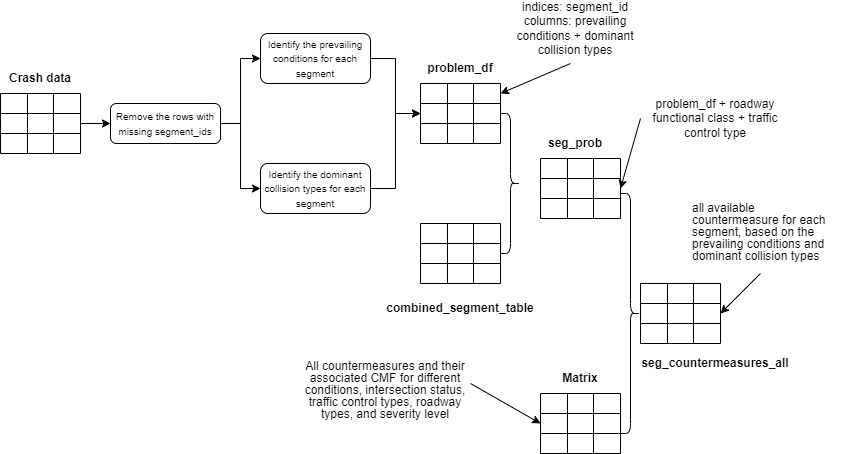

### 2.3

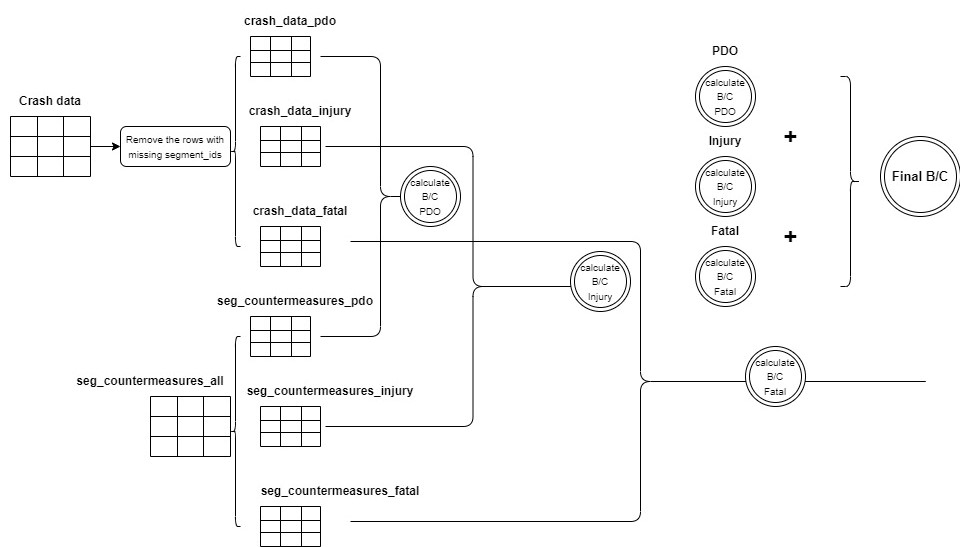

#### Finding the number of crashes that are affected by each countermeasure for each location

In [342]:
# Split the data frames for each segment based on the severity level


# Fatal
seg_countermeasures_fatal = [x.loc[x['CMF Type'].str.contains('Fatal')].reset_index(drop = True) for \
                             x in seg_countermeasures_all]

# Injury
seg_countermeasures_injury = [x.loc[x['CMF Type'].str.contains('Injury')].reset_index(drop = True) for \
                             x in seg_countermeasures_all]

# PDO
seg_countermeasures_pdo = [x.loc[x['CMF Type'].str.contains('PDO')].reset_index(drop = True) for \
                             x in seg_countermeasures_all]

In [302]:
crash_data_reduced = crash_data[['ccn', 'severity', 'collision_type', 'num_speed', 'num_ped_involved', 
                                         'num_bike_involved', 'is_wet', 'is_dark', 'intersection_id', 'segment_id']]

print(crash_data.shape)
print(crash_data_reduced.shape)

(83089, 15)
(83089, 10)


We need to revise the crash data: if we have a crash with nighttime, ped, wet, speed, or bike, we create another row for it in the crash table, with everything the same, except the collision_type

In [303]:
x1 = crash_data_reduced.loc[crash_data_reduced.num_speed > 0]
x1['collision_type'] = 'Speed related'

C:\Users\sina\AppData\Local\Temp/ipykernel_1292/1066431815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1['collision_type'] = 'Speed related'


In [304]:
x2 = crash_data_reduced.loc[crash_data_reduced.num_ped_involved > 0]
x2['collision_type'] = 'Pedestrian'

C:\Users\sina\AppData\Local\Temp/ipykernel_1292/739382332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x2['collision_type'] = 'Pedestrian'


In [305]:
x3 = crash_data_reduced.loc[crash_data_reduced.num_bike_involved > 0]
x3['collision_type'] = 'Bike'

C:\Users\sina\AppData\Local\Temp/ipykernel_1292/325446484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x3['collision_type'] = 'Bike'


In [306]:
x4 = crash_data_reduced.loc[crash_data_reduced.is_dark == 1]
x4['collision_type'] = 'Nighttime'

C:\Users\sina\AppData\Local\Temp/ipykernel_1292/1417181719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x4['collision_type'] = 'Nighttime'


In [307]:
x5 = crash_data_reduced.loc[crash_data_reduced.is_wet == 1]
x5['collision_type'] = 'Wet road'

C:\Users\sina\AppData\Local\Temp/ipykernel_1292/4099595882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x5['collision_type'] = 'Wet road'


In [329]:
crash_data_reduced = pd.concat([crash_data_reduced, x1, x2, x3, x4, x5], ignore_index= True)


# Now that we have crash conditions as collision types, we can remove the rows with null collision types
crash_data_reduced.dropna(subset= ['collision_type'], inplace= True)

# We have to drop the full duplicates
crash_data_reduced.drop_duplicates(inplace= True)

 This new data frames contains all collision types

In [330]:
# Check

print(crash_data_reduced.shape)

(106488, 10)


Create three tables based on the severity level

In [331]:
# Fatal
crash_data_fatal = crash_data_reduced.loc[crash_data_reduced.severity == 'Fatal']

# Injury
crash_data_injury = crash_data_reduced.loc[crash_data_reduced.severity == 'Injury']

# PDO
crash_data_pdo = crash_data_reduced.loc[crash_data_reduced.severity == 'PDO']

In [332]:
# Check

crash_data_pdo.loc[crash_data_pdo.segment_id == 1]

,ccn,severity,collision_type,num_speed,num_ped_involved,num_bike_involved,is_wet,is_dark,intersection_id,segment_id
80880,19087878,PDO,Nighttime,0,0,0,0,1,14636.0,1.0
81604,19115635,PDO,Nighttime,0,0,0,1,1,14636.0,1.0
101782,19115635,PDO,Wet road,0,0,0,1,1,14636.0,1.0


In [344]:
seg_countermeasures_pdo[0]

,Countermeasure,Condition,Intersection Related,Traffic Control Type,Roadway Type,CMF Type,CMF Value,segment_id
0,converting four-lane roadways to three-lane ro...,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.530,1.0
1,flatten side slopes,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.580,1.0
2,implement mobile automated speed enforcement s...,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.910,1.0
3,improve pavement condition as measured by inte...,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.070,1.0
4,improve street lighting illuminance and unifor...,Nighttime,no,Non-intersection,Collector,CMF_PDO,0.679,1.0
...,...,...,...,...,...,...,...,...
250,upgrade existing markings to wet-reflective pa...,Pedestrian,no,Non-intersection,Collector,CMF_PDO,0.825,1.0
251,upgrade existing markings to wet-reflective pa...,Rear End,no,Non-intersection,Collector,CMF_PDO,0.825,1.0
252,upgrade existing markings to wet-reflective pa...,Right Turn Hit Veh.,no,Non-intersection,Collector,CMF_PDO,0.825,1.0
253,upgrade existing markings to wet-reflective pa...,Side Swiped,no,Non-intersection,Collector,CMF_PDO,0.825,1.0


#### For each location:
#####     For each countermeasure:

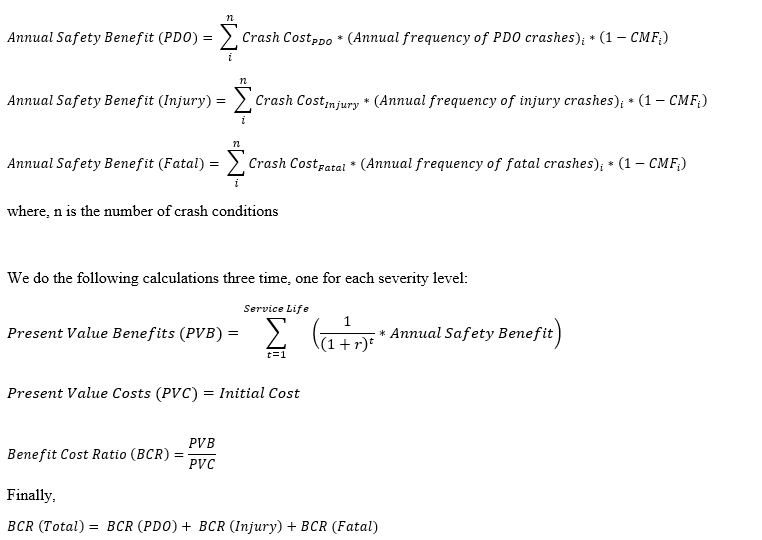

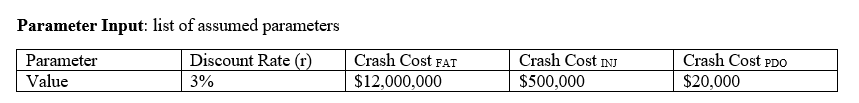

Assumptions:
1. Service life = 5
2. Countermeasure's cost = $10,000

In [465]:
from functools import reduce

def bc_ratio_pdo(seg):
    
    seg = seg.merge(crash_data_pdo, left_on= ['segment_id', 'Condition'],\
                                     right_on= ['segment_id', 'collision_type'], how = 'inner')
    
    seg = seg.sort_values(['Countermeasure', 'ccn', 'CMF Value'], ascending= False)
    
    seg = seg.loc[~ seg.duplicated(subset= ['Countermeasure', 'ccn'], keep= 'last')]
    
    seg_group = seg.groupby('Countermeasure')
    
    # Crash costs for PDO crashes = $20,000. This can be updated later based on more recent data.
    
    benefit = 20000 * (seg_group['CMF Value'].count() - seg_group['CMF Value'].sum())
    
    # r = discount rate: we use 3% here. This can be changed by the client!
    r = 0.03
    # t = service life of the countermeasure: we use 5 here. This can be changed later by Jianwei.
    t = 5
    
    # present value benefits
    pvb = reduce(lambda pvb, t: pvb + (1/(1+r)**t) * benefit, [0] + [*range(1, 6)])
    
    # present value costs = initial cost
    # Note! the fixed values of $10,000 will be replaced by actual values that will be provided by Jianwei
    
    pvc = 10000
    
    bc = pvb/pvc
    
    return(bc)

In [466]:
bc_loc_pdo = [bc_ratio_pdo(x) for x in seg_countermeasures_pdo] 

In [469]:
def bc_ratio_inj(seg):
    
    seg = seg.merge(crash_data_injury, left_on= ['segment_id', 'Condition'],\
                                     right_on= ['segment_id', 'collision_type'], how = 'inner')
    
    seg = seg.sort_values(['Countermeasure', 'ccn', 'CMF Value'], ascending= False)
    
    seg = seg.loc[~ seg.duplicated(subset= ['Countermeasure', 'ccn'], keep= 'last')]
    
    seg_group = seg.groupby('Countermeasure')
    
    # Crash costs for Injury crashes = $500,000. This can be updated later based on more recent data.
    
    benefit = 500000 * (seg_group['CMF Value'].count() - seg_group['CMF Value'].sum())
    
    # r = discount rate: we use 3% here. This can be changed by the client!
    r = 0.03
    # t = service life of the countermeasure: we use 5 here. This can be changed later by Jianwei.
    t = 5
    
    # present value benefits
    pvb = reduce(lambda pvb, t: pvb + (1/(1+r)**t) * benefit, [0] + [*range(1, 6)])
    
    # present value costs = initial cost
    # Note! the fixed values of $10,000 will be replaced by actual values that will be provided by Jianwei
    
    pvc = 10000
    
    bc = pvb/pvc
    
    return(bc)

In [470]:
bc_loc_inj = [bc_ratio_inj(x) for x in seg_countermeasures_injury] 

In [471]:
def bc_ratio_fatal(seg):
    
    seg = seg.merge(crash_data_fatal, left_on= ['segment_id', 'Condition'],\
                                     right_on= ['segment_id', 'collision_type'], how = 'inner')
    
    seg = seg.sort_values(['Countermeasure', 'ccn', 'CMF Value'], ascending= False)
    
    seg = seg.loc[~ seg.duplicated(subset= ['Countermeasure', 'ccn'], keep= 'last')]
    
    seg_group = seg.groupby('Countermeasure')
    
    # Crash costs for Fatal crashes = $12,000,000. This can be updated later based on more recent data.
    
    benefit = 12000000 * (seg_group['CMF Value'].count() - seg_group['CMF Value'].sum())
    
    # r = discount rate: we use 3% here. This can be changed by the client!
    r = 0.03
    # t = service life of the countermeasure: we use 5 here. This can be chamged later by Jianwei.
    t = 5
    
    # present value benefits
    pvb = reduce(lambda pvb, t: pvb + (1/(1+r)**t) * benefit, [0] + [*range(1, 6)])
    
    # present value costs = initial cost
    # Note! the fixed values of $10,000 will be replaced by actual values that will be provided by Jianwei
    
    pvc = 10000
    
    bc = pvb/pvc
    
    return(bc)

In [472]:
bc_loc_fatal = [bc_ratio_fatal(x) for x in seg_countermeasures_fatal] 

In [513]:
bc_loc_1 = [bc_loc_pdo[i].add(bc_loc_inj[i], fill_value = 0) for i in range(len(bc_loc_pdo))]

#### Total BC ratios for each countermeasure

In [517]:
bc_loc_total = [bc_loc_1[i].add(bc_loc_fatal[i], fill_value= 0) for i in range(len(bc_loc_1))]

In [519]:
# Check

bc_loc_total[1000]

Countermeasure
add 3-inch yellow retroreflective sheeting to signal backplates    2.747824
install dynamic signal warning flashers                            3.407302
install intersection lighting                                      3.810316
modify signal phasing (implement a leading pedestrian interval)    1.831883
provide a left-turn lane on both major-road approaches             3.480577
provide a left-turn lane on one major-road approach                1.831883
provide a right-turn lane on both major-road approaches            1.465506
provide a right-turn lane on one major-road approach               0.732753
Name: CMF Value, dtype: float64

## 2.4

In [523]:
best_cm = [x.nlargest(1) for x in bc_loc_total]

In [525]:
best_cm[1000]

Countermeasure
install intersection lighting    3.810316
Name: CMF Value, dtype: float64

# Notes:

1. I used the crash data for 4 years to have a bigger sample size. The actual analysis should be done, using the crash data for a single year.
2. Each segment in the 'combined_segment_table' has an intersection_id and a traffic_control_type column. I used those in this analysis. Meaning that the code can hande both roadway segments and intersections.

In this analysis, only one countermeasure can be used at a time. The challenges of using more than one countermeasure at the same time are:
1. Calculating the total number of crashes affected by implementing multiple countermeasures.
2. Calculating a single CMF value for crashes, which are affected by more than one countermeasure.